# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

## Loads the Database

In [2]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = torch.tensor((df[df.columns[3:]].to_numpy())).float()

  return dataIdentifier, trainInfo, df
dataIdentifier, trainInfo, df = preprocessData()

props = df.columns[3:].tolist()
nmat, nprop = trainInfo.size()

## Loads the truss

In [3]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(6)
#Changes the force
#bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}

#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

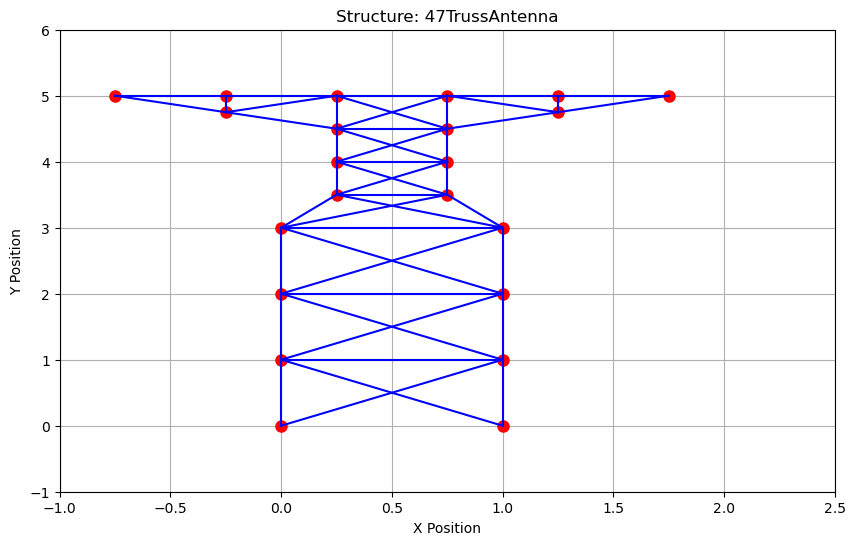

In [4]:
# Create a plot
plt.figure(figsize=(10, 6))
plt.title(f"Structure: {exampleName}")

# Plot nodes
plt.plot(nodeXY[:, 0], nodeXY[:, 1], 'ro', markersize=8)

# Plot elements
for i in range(len(connectivity)):
    node1 = connectivity[i, 0]
    node2 = connectivity[i, 1]
    x = [nodeXY[node1, 0], nodeXY[node2, 0]]
    y = [nodeXY[node1, 1], nodeXY[node2, 1]]
    plt.plot(x, y, 'b')


# Set axis limits
plt.xlim(-1, 2.5)
plt.ylim(-1, 6)

# Add labels
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.grid()
plt.show()

## SELECT CONSTRAINTS AND OBJECTIVES HERE

In [5]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3}}


objectives = {'cost': {'isOn':True},\
              'mass': {'isOn':True}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Three or more entries have isOn=True')

## ---------------------------------------------------------------------------------------

## Defines problem

In [19]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.termination.default import DefaultMultiObjectiveTermination

class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo , constraints, objectives, nc, no, nmat, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, 49):
            variables[f"x{k:02}"] = Real(bounds=(2e-8, 2e-3))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo=trainInfo
        self.constraints=constraints
        self.objectives=objectives
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, 49)])
        
        matprop=trainInfo[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)
        
  
problem = MixedVarsZDT1(truss,trainInfo , constraints, objectives, nc, no, nmat)

    
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=100,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

termination=('n_gen', 350)

## Runs the solver

In [20]:
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.2129996812 |  3.700016E+04 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |  8.8249697052 |             - |             -
     3 |      300 |      4 |  0.000000E+00 |  2.4109131133 |  1.0000000000 |         ideal
     4 |      400 |      2 |  0.000000E+00 |  0.6301372314 |  0.5008287458 |         ideal
     5 |      500 |      3 |  0.000000E+00 |  0.1422860879 |  0.0887422215 |         ideal
     6 |      600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1302770108 |         ideal
     7 |      700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.2535141827 |         ideal
     8 |      800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0138548970 |             f
     9 |      900 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0155077529 |         ideal
    10 |     1000 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0181721535 |             f

    89 |     8900 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    90 |     9000 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    91 |     9100 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0027005114 |             f
    92 |     9200 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0019541165 |             f
    93 |     9300 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0081506724 |         ideal
    94 |     9400 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0042338057 |         nadir
    95 |     9500 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0095617828 |         nadir
    96 |     9600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0014078612 |             f
    97 |     9700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0102450845 |         nadir
    98 |     9800 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0183249443 |         nadir
    99 |     9900 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   180 |    18000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   181 |    18100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   182 |    18200 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   183 |    18300 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0034289970 |         nadir
   184 |    18400 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   185 |    18500 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0026412414 |             f
   186 |    18600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0175682357 |         nadir
   187 |    18700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0006407632 |             f
   188 |    18800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0006407632 |             f
   189 |    18900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0105083076 |         nadir
   190 |    19000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   271 |    27100 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0008465309 |             f
   272 |    27200 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0088026903 |         nadir
   273 |    27300 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0030831617 |             f
   274 |    27400 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0019727744 |             f
   275 |    27500 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0019727744 |             f
   276 |    27600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0039411244 |             f
   277 |    27700 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   278 |    27800 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   279 |    27900 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0105411629 |         nadir
   280 |    28000 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0096130970 |         nadir
   281 |    28100 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0015468414 |             f

## Plots the result

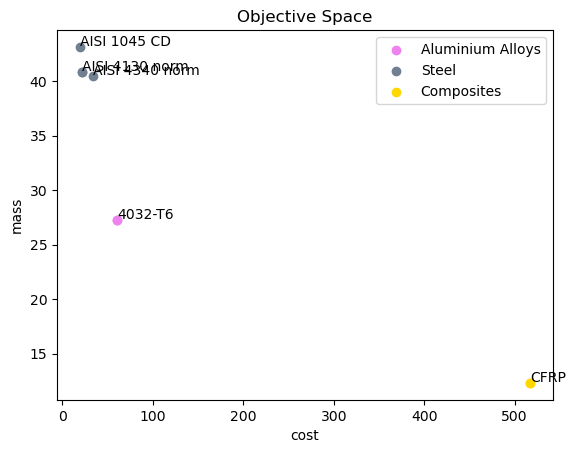

[{'x01': 47, 'x02': 0.0006028439732116314, 'x03': 0.0002622106010612949, 'x04': 0.0002523763935911835, 'x05': 0.0006506766180058812, 'x06': 3.150134863868282e-05, 'x07': 0.0006764639323048898, 'x08': 0.0001643647229564307, 'x09': 0.00020073998857107663, 'x10': 0.0007289545506162272, 'x11': 6.438716068262682e-06, 'x12': 0.0006283751279582885, 'x13': 3.538916742238892e-05, 'x14': 1.934660340601024e-06, 'x15': 0.0005354418612876122, 'x16': 6.466635189965837e-05, 'x17': 0.0003809020651663772, 'x18': 1.4491764637197803e-06, 'x19': 2.2349664652889427e-05, 'x20': 0.0006513280103668162, 'x21': 0.00016036581819692662, 'x22': 0.0003814029120061315, 'x23': 0.0003654812346650533, 'x24': 0.00020253608696083902, 'x25': 0.0003509883699680166, 'x26': 0.00016409622231073435, 'x27': 0.0002869738634020082, 'x28': 0.00029660392744951865, 'x29': 0.0002565627357357406, 'x30': 0.0004275694331023017, 'x31': 0.00048544376565768955, 'x32': 0.0004258458776595507, 'x33': 0.00029558918626329105, 'x34': 3.111596913

In [21]:
X = res.X
F = res.F
G = res.G
Z_res = [[d['x01']] for d in X]


names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}

for xData in Z_res:
    matname = dataIdentifier['name'][int(xData[0])]
    mattype = dataIdentifier['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    
unique_labels = list(set(types))

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}


for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))
        


# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    #if i == 3:  # Exclude the third value (index 2)
        #continue
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)


# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")


# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Integer/Integer_mass_cost.png',bbox_inches='tight', dpi = 200)
plt.show()
print(X)

In [22]:
objectives2 = {'cost': {'isOn':True},\
              'mass': {'isOn':False}, \
              'co2': {'isOn':True},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Three or more entries have isOn=True')

In [23]:
class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo , constraints, objectives2, nc, no, nmat, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, 49):
            variables[f"x{k:02}"] = Real(bounds=(2e-8, 2e-3))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo=trainInfo
        self.constraints=constraints
        self.objectives=objectives2
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, 49)])
        
        matprop=trainInfo[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives2['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives2['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives2['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives2['water']['isOn']):
            obj_values.append(water)
            
        if(objectives2['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives2['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)
        
  
problem2 = MixedVarsZDT1(truss,trainInfo , constraints, objectives2, nc, no, nmat)

In [24]:
start = time.perf_counter()
res2 = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.2129996812 |  3.700016E+04 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |  8.8249697052 |             - |             -
     3 |      300 |      2 |  0.000000E+00 |  2.4707742610 |  3.3726215167 |         ideal
     4 |      400 |      3 |  0.000000E+00 |  0.7012653364 |  0.2712884129 |         ideal
     5 |      500 |      3 |  0.000000E+00 |  0.1345439833 |  0.1738551891 |         ideal
     6 |      600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1433514120 |         ideal
     7 |      700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     1000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1134043968 |             f

    89 |     8900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    90 |     9000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0000959666 |             f
    91 |     9100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0490977285 |         ideal
    92 |     9200 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0710317851 |         ideal
    93 |     9300 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0098089938 |             f
    94 |     9400 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0243651984 |         ideal
    95 |     9500 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0211281571 |             f
    96 |     9600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0350873807 |         ideal
    97 |     9700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    98 |     9800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0031033919 |         ideal
    99 |     9900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0965854360 |         ideal

   180 |    18000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0017480200 |             f
   181 |    18100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0087863714 |         nadir
   182 |    18200 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   183 |    18300 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   184 |    18400 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0237864781 |         ideal
   185 |    18500 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0365110649 |         ideal
   186 |    18600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   187 |    18700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0033686917 |         ideal
   188 |    18800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0114969169 |             f
   189 |    18900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0025828381 |         ideal
   190 |    19000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0017396373 |             f

   271 |    27100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0002384338 |             f
   272 |    27200 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0002384338 |             f
   273 |    27300 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0153979951 |         ideal
   274 |    27400 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0168100656 |         ideal
   275 |    27500 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0001045946 |             f
   276 |    27600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0001045946 |             f
   277 |    27700 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0001045946 |             f
   278 |    27800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0001045946 |             f
   279 |    27900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0052701877 |             f
   280 |    28000 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0053943300 |             f
   281 |    28100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

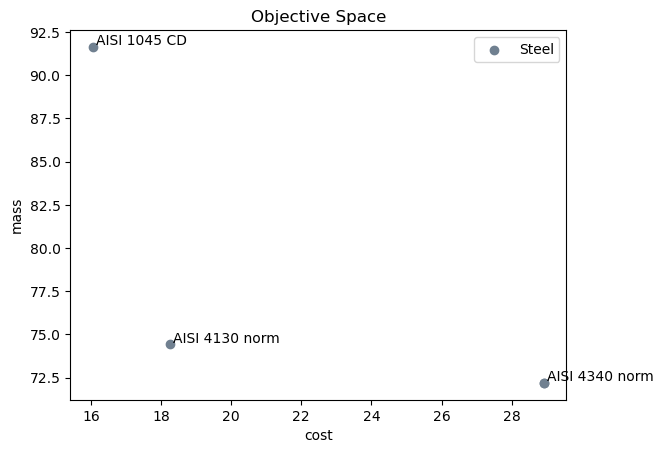

[{'x01': 47, 'x02': 0.0006028439732116314, 'x03': 0.0002622106010612949, 'x04': 0.0002523763935911835, 'x05': 0.0006506766180058812, 'x06': 3.150134863868282e-05, 'x07': 0.0006764639323048898, 'x08': 0.0001643647229564307, 'x09': 0.00020073998857107663, 'x10': 0.0007289545506162272, 'x11': 6.438716068262682e-06, 'x12': 0.0006283751279582885, 'x13': 3.538916742238892e-05, 'x14': 1.934660340601024e-06, 'x15': 0.0005354418612876122, 'x16': 6.466635189965837e-05, 'x17': 0.0003809020651663772, 'x18': 1.4491764637197803e-06, 'x19': 2.2349664652889427e-05, 'x20': 0.0006513280103668162, 'x21': 0.00016036581819692662, 'x22': 0.0003814029120061315, 'x23': 0.0003654812346650533, 'x24': 0.00020253608696083902, 'x25': 0.0003509883699680166, 'x26': 0.00016409622231073435, 'x27': 0.0002869738634020082, 'x28': 0.00029660392744951865, 'x29': 0.0002565627357357406, 'x30': 0.0004275694331023017, 'x31': 0.00048544376565768955, 'x32': 0.0004258458776595507, 'x33': 0.00029558918626329105, 'x34': 3.111596913

In [26]:
X2 = res2.X
F2 = res2.F
G2 = res2.G
Z_res2 = [[d['x01']] for d in X2]


names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}

for xData in Z_res2:
    matname = dataIdentifier['name'][int(xData[0])]
    mattype = dataIdentifier['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    
unique_labels = list(set(types))

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}


for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))
        


# add scatter plot for each unique label
for i, (x, y) in enumerate(F2):
    #if i == 3:  # Exclude the third value (index 2)
        #continue
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)


# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")


# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Integer/Integer_cost_co2.png',bbox_inches='tight', dpi = 200)
plt.show()
print(X)

In [19]:
objectives3 = {'cost': {'isOn':False},\
              'mass': {'isOn':True}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': True}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Three or more entries have isOn=True')

In [20]:
class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo , constraints, objectives3, nc, no, nmat, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, 49):
            variables[f"x{k:02}"] = Real(bounds=(2e-8, 2e-3))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo=trainInfo
        self.constraints=constraints
        self.objectives=objectives3
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, 49)])
        
        matprop=trainInfo[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives3['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives3['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives3['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives3['water']['isOn']):
            obj_values.append(water)
            
        if(objectives3['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives3['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)
        
  
problem3 = MixedVarsZDT1(truss,trainInfo , constraints, objectives3, nc, no, nmat)

In [21]:
start = time.perf_counter()
res3 = minimize(problem3,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.2129996812 |  3.700016E+04 |             - |             -
     2 |      200 |      2 |  0.000000E+00 |  8.8249697052 |             - |             -
     3 |      300 |      5 |  0.000000E+00 |  2.4676914670 |  0.0586419053 |         ideal
     4 |      400 |      5 |  0.000000E+00 |  0.7176305668 |  0.1735478681 |         ideal
     5 |      500 |      7 |  0.000000E+00 |  0.1746583994 |  0.0062080345 |         ideal
     6 |      600 |      8 |  0.000000E+00 |  0.0019769861 |  0.0612915416 |             f
     7 |      700 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0567514500 |             f
     8 |      800 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0336353646 |             f
     9 |      900 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0240507905 |             f
    10 |     1000 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0100576091 |         ideal

    89 |     8900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0027945310 |             f
    90 |     9000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0009774134 |             f
    91 |     9100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018301015 |             f
    92 |     9200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022033389 |             f
    93 |     9300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0029001136 |             f
    94 |     9400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0006548432 |             f
    95 |     9500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021123807 |             f
    96 |     9600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0030005360 |             f
    97 |     9700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0005324065 |             f
    98 |     9800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0011587666 |             f
    99 |     9900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018864022 |             f

   180 |    18000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012277670 |             f
   181 |    18100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018764771 |             f
   182 |    18200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0025505099 |             f
   183 |    18300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0004332263 |             f
   184 |    18400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0011939111 |             f
   185 |    18500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021363802 |             f
   186 |    18600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022964568 |             f
   187 |    18700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0024591871 |             f
   188 |    18800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0066193605 |         nadir
   189 |    18900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0005307034 |             f
   190 |    19000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012356697 |             f

   271 |    27100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012902865 |             f
   272 |    27200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014905362 |             f
   273 |    27300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0048399459 |         nadir
   274 |    27400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0007052678 |             f
   275 |    27500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0008194111 |             f
   276 |    27600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0135231318 |         nadir
   277 |    27700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0002811004 |             f
   278 |    27800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0009128217 |             f
   279 |    27900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016005467 |             f
   280 |    28000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019117145 |             f
   281 |    28100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023039264 |             f

   362 |    36200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012978266 |             f
   363 |    36300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016906501 |             f
   364 |    36400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019253538 |             f
   365 |    36500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0021219538 |             f
   366 |    36600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0023198951 |             f
   367 |    36700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0027066605 |             f
   368 |    36800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0007073505 |             f
   369 |    36900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0010262326 |             f
   370 |    37000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016540523 |             f
   371 |    37100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0020698131 |             f
   372 |    37200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0022839685 |             f

   453 |    45300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0008576901 |             f
   454 |    45400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012806716 |             f
   455 |    45500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0015075666 |             f
   456 |    45600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0538185416 |         nadir
   457 |    45700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0494096831 |         nadir
   458 |    45800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0002929701 |             f
   459 |    45900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0005876879 |             f
   460 |    46000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0008663587 |             f
   461 |    46100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0010449233 |             f
   462 |    46200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013155586 |             f
   463 |    46300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0474435677 |         nadir

Solution not limited by the areas


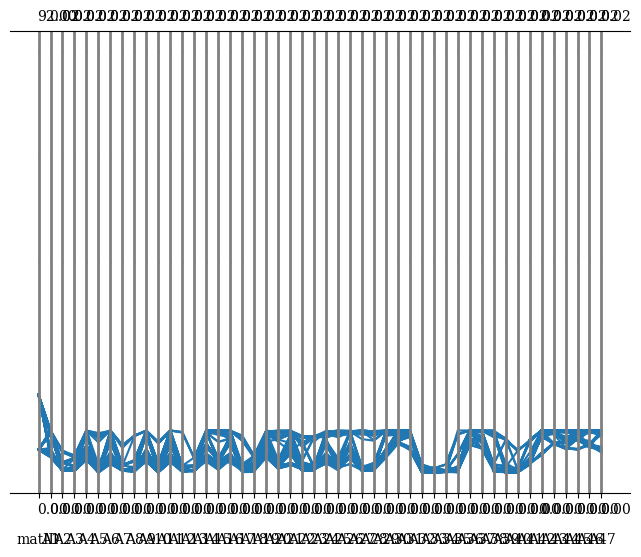

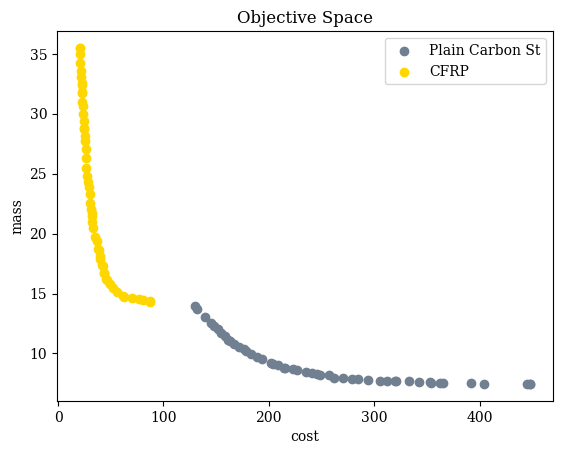

[{'x01': 5, 'x02': 0.000508233835267618, 'x03': 6.044582282741674e-05, 'x04': 0.0001190864636592339, 'x05': 0.00050950048606923, 'x06': 1.7426077808303675e-06, 'x07': 0.00048132929671006506, 'x08': 7.863380926977431e-05, 'x09': 0.00012705914657608014, 'x10': 0.0005292719392592695, 'x11': 8.336545752789555e-05, 'x12': 0.0005607211272644762, 'x13': 1.0605746378846365e-05, 'x14': 4.064707582850073e-06, 'x15': 0.0004496744275030719, 'x16': 2.553756210350613e-05, 'x17': 0.00035003447846703605, 'x18': 7.132017198131035e-05, 'x19': 2.1551915929420424e-05, 'x20': 0.0003703807663053616, 'x21': 0.0002568327991234048, 'x22': 0.0003087492280571898, 'x23': 5.3439195115970995e-05, 'x24': 6.468931732061595e-05, 'x25': 0.00023140715644904736, 'x26': 2.2510114896362177e-06, 'x27': 0.0002836597050649319, 'x28': 0.00015315256880748707, 'x29': 6.726691349692723e-05, 'x30': 0.0002983122594620376, 'x31': 0.00048347297785042345, 'x32': 0.0003555098189013434, 'x33': 5.968323733596553e-05, 'x34': 3.35669902238

In [22]:
from pymoo.visualization.pcp import PCP
X3 = res3.X
F3 = res3.F
G3 = res3.G
Z_res3 = [[d['x01']] for d in X3]




labels = list(res3.opt[0].X.keys())
labels_x = ['matID'] + [f'A{i}' for i in range(1, 48)]
bounds = np.array([problem.vars[name].bounds for name in labels]).T


X3 = np.array([[sol.X[name] for name in labels] for sol in res3.opt])

plot1 = PCP(labels=labels_x, bounds=bounds)
plot1.set_axis_style(color="grey", alpha=1)
plot1.add(X3)

plot1.show()
plt.savefig('./figures_Integer/PCP.png',bbox_inches='tight', dpi = 200)


# Maybe the solution is limited by the limits in areas. Example, you want to minimize the compliance but
# you have a maximum area, so you can't reduce the compliance further

upper_bounds = bounds[1, 1:]*0.999
lower_bounds = bounds[0, 1:]*1.001



# Check if each row of X is within the limits
is_within_limits = np.logical_and(np.all(X3[:,1:] >= lower_bounds, axis=1), np.all(X3[:,1:] <= upper_bounds, axis=1))

# Print the results
if np.all(is_within_limits):
    print("Solution not limited by the areas")
else:
    print("Solution limited by the areas")



    

names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}
material_name_dict = {}  # Dictionary to map material types to material names

for xData in Z_res3:
    matname = dataIdentifier['name'][int(xData[0])]
    mattype = dataIdentifier['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    material_name_dict[mattype] = matname  # Populate the material name dictionary

unique_labels = list(set(types))

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))

# add scatter plot for each unique label
for i, (x, y) in enumerate(F3):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = material_name_dict[mattype]  # Use material name as the label
    ax.scatter(x, y, color=color, label=label)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)

# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(material_name_dict[label])  # Use material name as the label
    legend_dict[label].set_color(mat_colors[label])

ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Integer/Integer_compliance_mass.png', bbox_inches='tight', dpi=200)
plt.show()
print(X)